## <span style="color:#db7d60">Setup</span>

In [2]:
%load_ext autoreload
%autoreload 2

import json
import math
import pickle
import numpy as np
import pandas as pd
import textwrap
import sys
from pathlib import Path
from IPython.display import display, Markdown
import matplotlib.pyplot as plt

# pUtil needs to be loaded from the root directory
parent_dir = Path().resolve().parent
sys.path.insert(0, str(parent_dir))

import pUtil
from analysis_common import *
import data_manager
import analysis as anal

import vector
from particle import Particle
from particle import PDGID

plt.rcParams['figure.figsize'] = (21, 6)

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.expand_frame_repr', False)

/global/homes/e/eshy/.local/lib/python3.11/site-packages/coffea/nanoevents/schemas/fcc.py:5: FutureWarning: In version 2025.1.0 (target date: 2024-12-31 11:59:59-06:00), this will be an error.
To raise these warnings as errors (and get stack traces to find out where they're called), run
    import warnings
    warnings.filterwarnings("error", module="coffea.*")
after the first `import coffea` or use `@pytest.mark.filterwarnings("error:::coffea.*")` in pytest.
Issue: coffea.nanoevents.methods.vector will be removed and replaced with scikit-hep vector. Nanoevents schemas internal to coffea will be migrated. Otherwise please consider using that package!.
  from coffea.nanoevents.methods import vector


## <span style="color:#db7d60">Analysis</span>

In [3]:
model_name = 'model_5_9_1'
input_leading_path = pUtil.get_model_preparation_dir(model_name) / 'real_leading_test_particles.csv'

columns = ["num_particles", "pdgid", "e", "px", "py", "pz", "pt", "eta", "theta", "phi"]
real_df = pd.read_csv(input_leading_path, sep=" ", names=columns, engine="c", header=None)

(array([ 852., 1738., 1220.,  539.,  244.,  126.,  103.,   65.,   72.,
          72.,   66.,   78.,   84.,   85.,  106.,  102.,  138.,  108.,
         147.,  164.,  153.,  168.,  189.,  212.,  204.,  256.,  269.,
         288.,  266.,  283.,  346.,  386.,  418.,  395.,  420.,  495.,
         562.,  532.,  560.,  633.,  685.,  692.,  693.,  792.,  808.,
         781.,  826.,  872.,  865.,  876.,  912.,  887.,  893.,  908.,
         967.,  980., 1006.,  956., 1063.,  952., 1003., 1028.,  954.,
         978.,  997.,  959., 1001., 1034.,  982.,  947.,  962.,  948.,
         932.,  945.,  965.,  901.,  826.,  897.,  848.,  825.,  829.,
         853.,  795.,  789.,  820.,  803.,  715.,  756.,  761.,  737.,
         674.,  732.,  642.,  708.,  644.,  648.,  631.,  615.,  603.,
         558.,  563.,  572.,  575.,  567.,  517.,  561.,  512.,  470.,
         480.,  450.,  488.,  477.,  420.,  460.,  425.,  425.,  403.,
         430.,  378.,  393.,  385.,  359.,  369.,  360.,  345.,  343.,
      

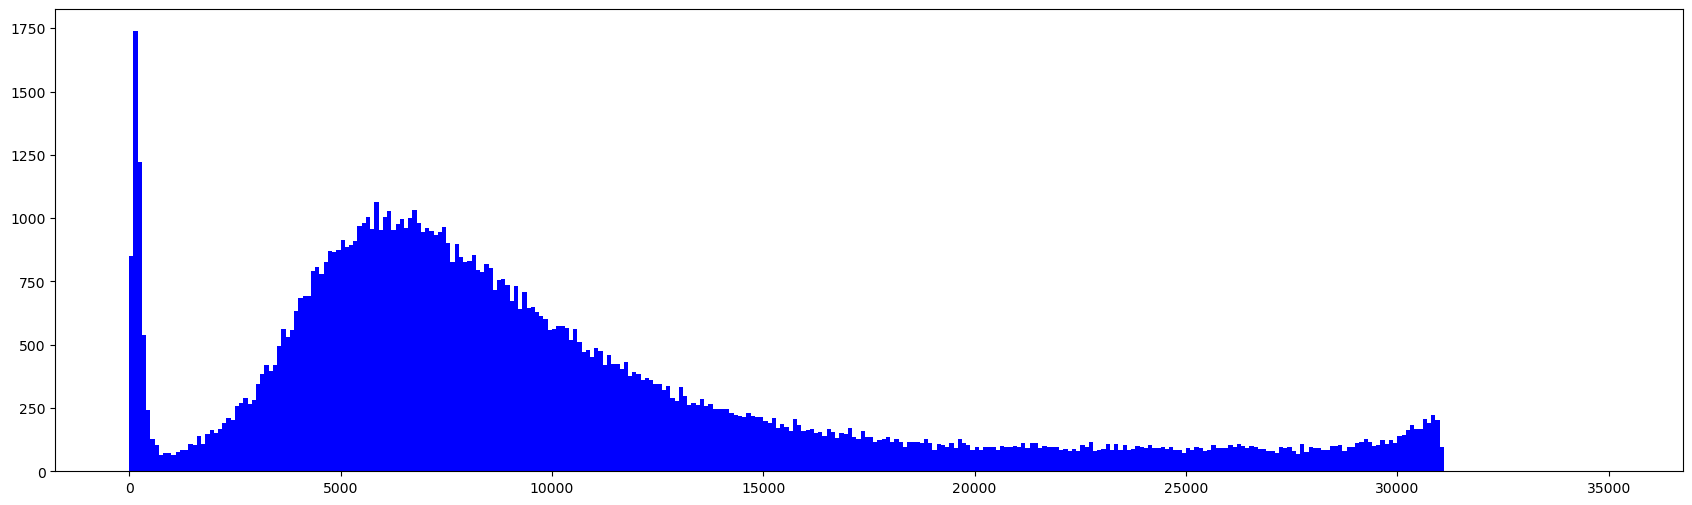

In [4]:
plt.hist(real_df['pt'], range=(0, 35000), bins=350, label='pt', color=anal.plotting.colors[0])

(array([0., 0., 0., ..., 0., 0., 0.]),
 array([0.000e+00, 1.000e-02, 2.000e-02, ..., 1.198e+01, 1.199e+01,
        1.200e+01]),
 <BarContainer object of 1200 artists>)

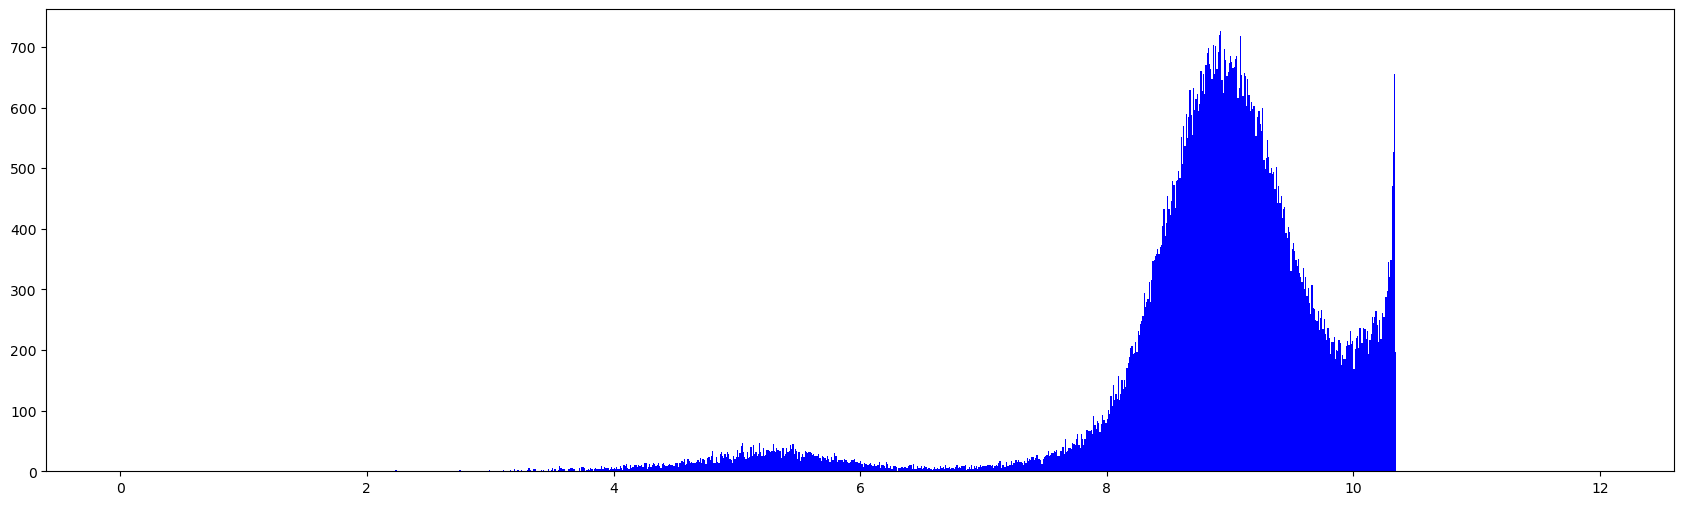

In [5]:
plt.hist(np.log(real_df['pt']), range=(0, 12), bins=1200, label='pt', color=anal.plotting.colors[0])

(array([3., 0., 1., ..., 0., 0., 0.]),
 array([1.57      , 1.57000067, 1.57000133, ..., 1.57079867, 1.57079933,
        1.5708    ]),
 <BarContainer object of 1200 artists>)

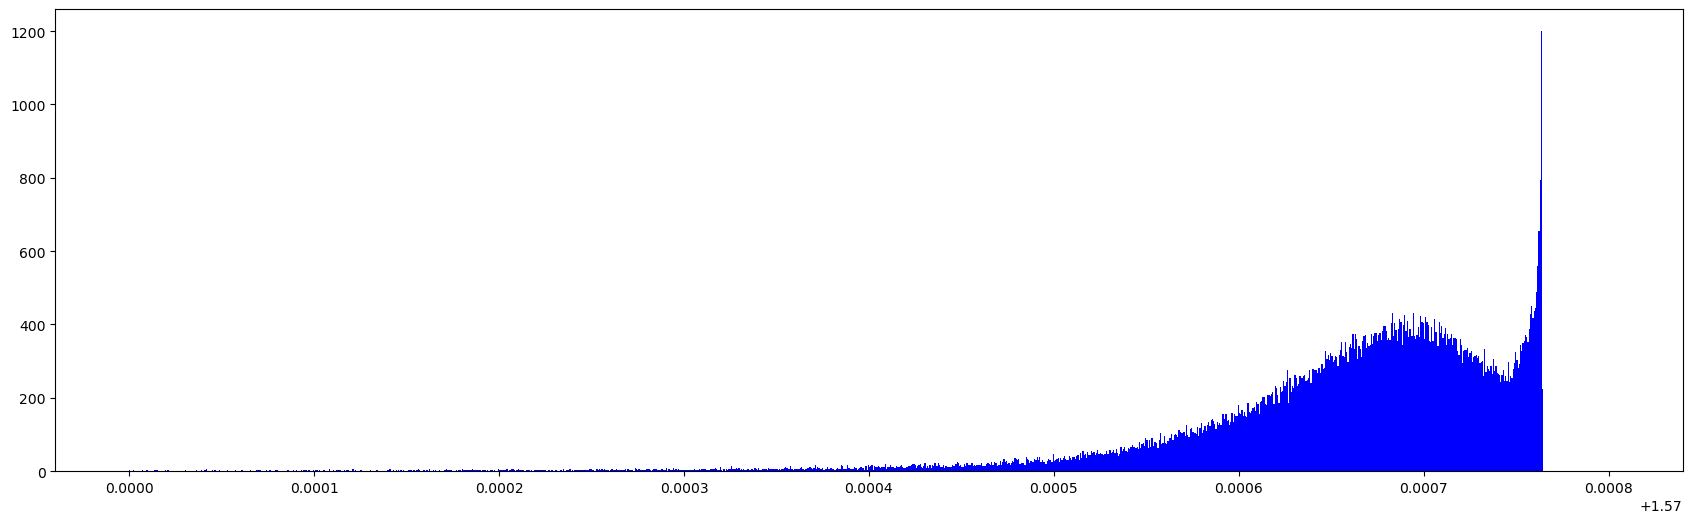

In [6]:
plt.hist(np.arctan(real_df['pt']), range=(1.57, 1.5708), bins=1200, label='pt', color=anal.plotting.colors[0])

Setup for quantile and log transformations.

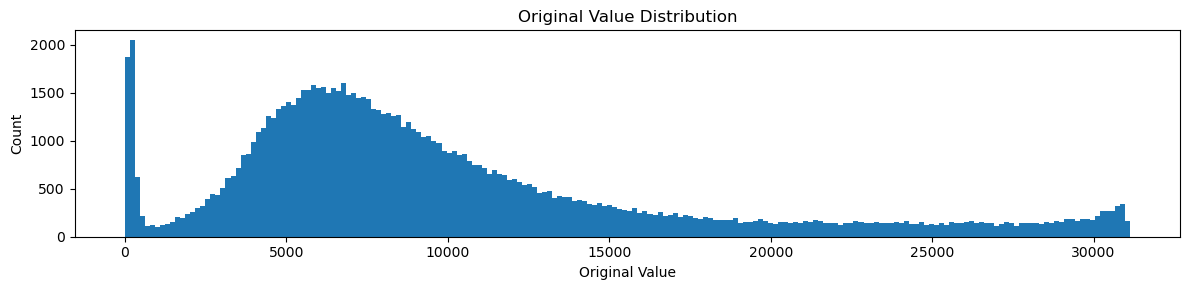

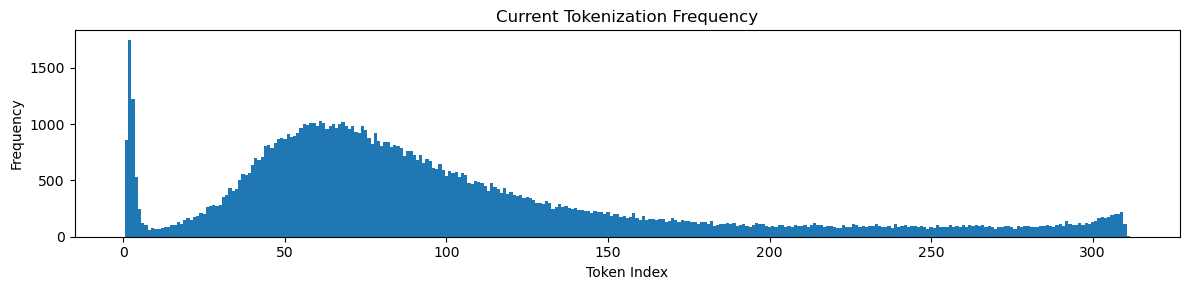

In [ ]:
original_values = real_df['pt']

current_bins = np.linspace(0, 35000, 350)
current_tokens = np.digitize(original_values, current_bins, right=False)

def plot_token_freq(tokens, title):
    counts = Counter(tokens)
    keys = sorted(counts.keys())
    values = [counts[k] for k in keys]
    plt.figure(figsize=(12, 3))
    plt.bar(keys, values, width=1.0)
    plt.title(title)
    plt.xlabel("Token Index")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()
    
plt.figure(figsize=(12, 3))
plt.hist(original_values, bins=200)
plt.title("Original Value Distribution")
plt.xlabel("Original Value")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

plot_token_freq(current_tokens, "Current Tokenization Frequency")

This is quantile transformation.

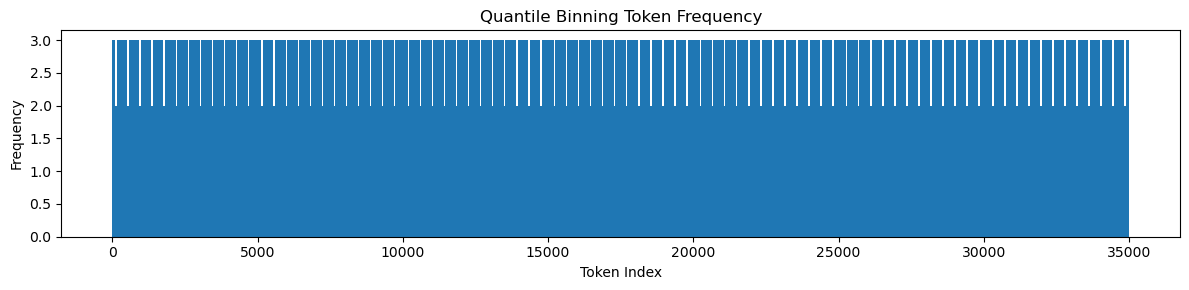

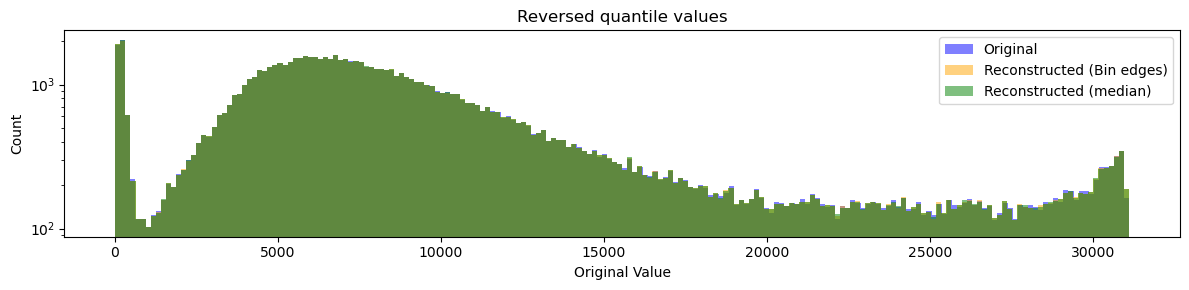

In [37]:
def quantile_tokenizer(values, num_bins=350, token_min=0):
    bin_edges = np.quantile(values, q=np.linspace(0, 1, num_bins + 1))
    bin_indices = np.digitize(values, bin_edges[1:-1], right=True)
    tokens = token_min + bin_indices
    return tokens, bin_edges

def quantile_detokenize(tokens, bin_edges, token_min=0):
    indices = tokens - token_min
    # Clip just in case
    indices = np.clip(indices, 0, len(bin_edges) - 2)
    # Use bin centers (can replace with per-bin means for more precision)
    return 0.5 * (bin_edges[indices] + bin_edges[indices + 1])

def build_bin_means(values, bin_edges):
    bin_indices = np.digitize(values, bin_edges[1:-1], right=True)
    bin_means = np.zeros(len(bin_edges) - 1)
    for i in range(len(bin_means)):
        in_bin = values[bin_indices == i]
        bin_means[i] = in_bin.mean() if len(in_bin) > 0 else 0.5 * (bin_edges[i] + bin_edges[i + 1])
    return bin_means

quantile_tokens, quantile_edges = quantile_tokenizer(original_values, num_bins=35000)
reversed_quantile_values = quantile_detokenize(quantile_tokens, quantile_edges)

mean_per_bin = build_bin_means(original_values, quantile_edges)
reconstructed_eta = mean_per_bin[quantile_tokens - 0]

plot_token_freq(quantile_tokens, "Quantile Binning Token Frequency")

plt.figure(figsize=(12, 3))
plt.yscale('log')
plt.hist(original_values, bins=200, color='blue', alpha=0.5)
plt.hist(reversed_quantile_values, bins=200, color='orange', alpha=0.5)
plt.hist(reconstructed_eta, bins=200, color='green', alpha=0.5)
plt.title("Reversed quantile values")
plt.xlabel("Original Value")
plt.ylabel("Count")
plt.legend(['Original', 'Reconstructed (Bin edges)', 'Reconstructed (median)'])
plt.tight_layout()
plt.show()

I am using 35,000 bins for quantile tokenization. I want to see if I can then reduce that to 350 (which is now many pt bins 5_9 has) and get good reconstruction for that many bins.

#### Update
- I am now using 350,000 bins and reducing it to 3,500 bins.
- Using 350k bins leads to better reconstruction of the quantile binning.
- 3.5k is not too bad of a vocab size increase (current is 350 for pt).


#### 1
The first thought is to just bin the quantile binning.

This is the ideal. This is what we want to achieve with training.


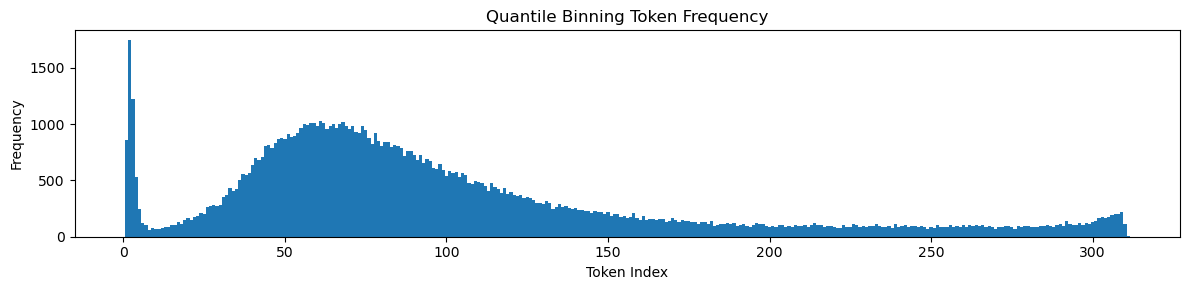

This the the quantile tokens (n_bins=35000) binned into 350 bins.


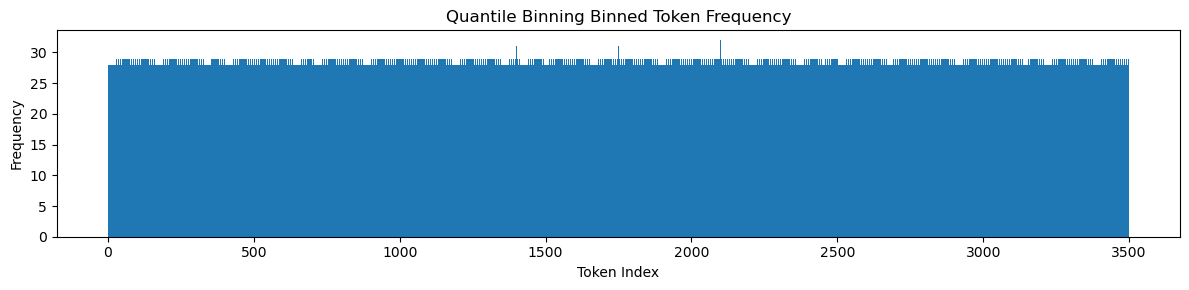

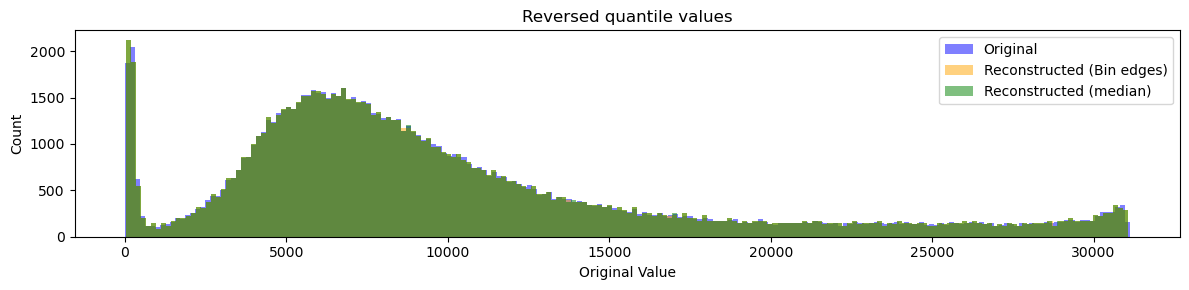

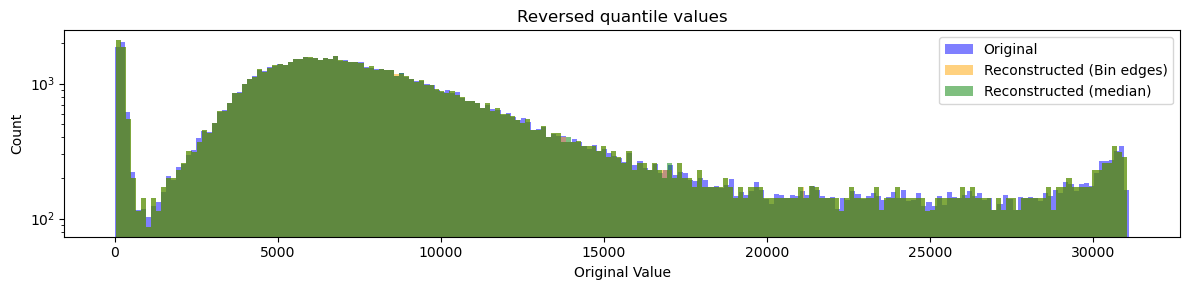

In [34]:
print("This is the ideal. This is what we want to achieve with training.")
plot_token_freq(current_tokens, "Quantile Binning Token Frequency")

quan_bin_bins = np.linspace(0, 35000, 3500)
quan_bin_bin_tokenized = np.digitize(quantile_tokens, quan_bin_bins)
# print(quan_bin_bins,quan_bin_bins.min(), quan_bin_bins.max(), quan_bin_bins.shape)
# print(quan_bin_bin_tokenized, quan_bin_bin_tokenized.min(), quan_bin_bin_tokenized.max(), quan_bin_bin_tokenized.shape)

print("This the the quantile tokens (n_bins=35000) binned into 350 bins.")
plot_token_freq(quan_bin_bin_tokenized, "Quantile Binning Binned Token Frequency")

reversed_binned_quantile_values = quantile_detokenize(quan_bin_bin_tokenized * 10, quantile_edges)
mean_per_binned_bin = build_bin_means(original_values, quantile_edges)
reconstructed_binned_pt = mean_per_binned_bin[quan_bin_bin_tokenized * 10 - 0]

n_bins_for_plotting = 200

plt.figure(figsize=(12, 3))
plt.hist(original_values, bins=n_bins_for_plotting, color='blue', alpha=0.5)
plt.hist(reversed_binned_quantile_values, bins=n_bins_for_plotting, color='orange', alpha=0.5)
plt.hist(reconstructed_binned_pt, bins=n_bins_for_plotting, color='green', alpha=0.5)
plt.title("Reversed quantile values")
plt.xlabel("Original Value")
plt.ylabel("Count")
plt.legend(['Original', 'Reconstructed (Bin edges)', 'Reconstructed (median)'])
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 3))
plt.yscale('log')
plt.hist(original_values, bins=n_bins_for_plotting, color='blue', alpha=0.5)
plt.hist(reversed_binned_quantile_values, bins=n_bins_for_plotting, color='orange', alpha=0.5)
plt.hist(reconstructed_binned_pt, bins=n_bins_for_plotting, color='green', alpha=0.5)
plt.title("Reversed quantile values")
plt.xlabel("Original Value")
plt.ylabel("Count")
plt.legend(['Original', 'Reconstructed (Bin edges)', 'Reconstructed (median)'])
plt.tight_layout()
plt.show()

This is Log1p tokenization.

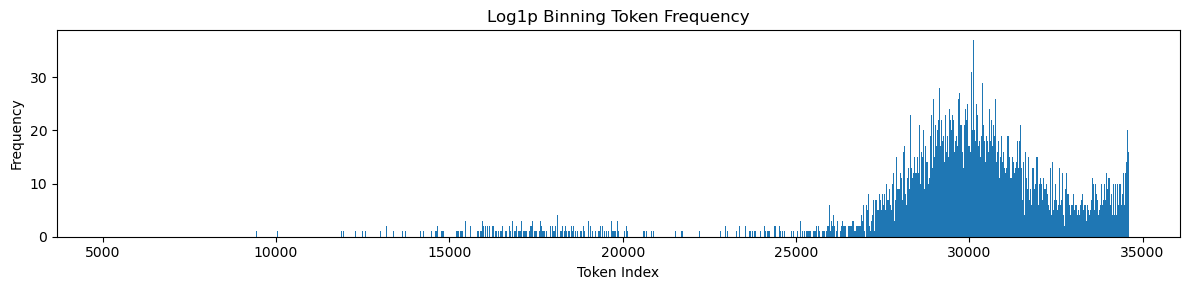

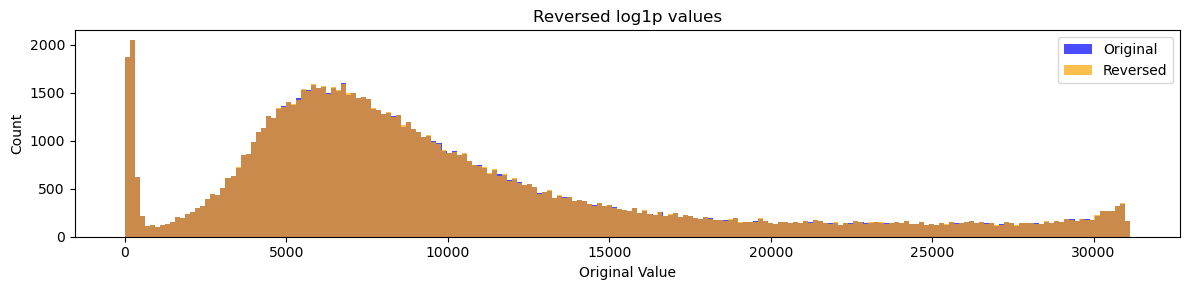

In [41]:
def log1p_tokenizer(values, num_bins=350, token_min=0):
    log_vals = np.log1p(values)
    log_min, log_max = np.log1p(0), np.log1p(35000)
    bins = np.linspace(log_min, log_max, num_bins + 1)
    bin_indices = np.digitize(log_vals, bins[1:-1], right=True)
    tokens = token_min + bin_indices
    return tokens, bins

def log1p_detokenize(tokens, bin_edges, token_min=0):
    indices = tokens - token_min
    # Clip for safety
    indices = np.clip(indices, 0, len(bin_edges) - 2)
    # Reconstruct log1p value using bin center
    log_vals = 0.5 * (bin_edges[indices] + bin_edges[indices + 1])
    # Invert log1p
    return np.expm1(log_vals)

log_tokens, log_bins = log1p_tokenizer(original_values, num_bins=35000)
reversed_log_values = log1p_detokenize(log_tokens, log_bins)

plot_token_freq(log_tokens, "Log1p Binning Token Frequency")

plt.figure(figsize=(12, 3))
plt.hist(original_values, bins=200, color='blue', alpha=0.7)
plt.hist(reversed_log_values, bins=200, color='orange', alpha=0.7)
plt.title("Reversed log1p values")
plt.xlabel("Original Value")
plt.ylabel("Count")
plt.legend(['Original', 'Reversed'])
plt.tight_layout()
plt.show()